# Binary classification test

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import seaborn as sns

## Introduction



```
# This is formatted as code
```

Binary predictors are a key tool in classification problems. These predictors are central to a variety of applications, from disease diagnosis to financial forecasting. In this computer lab, we will attempt to assess the quality of a set of binary predictors on balanced and unbalanced datasets using the quality estimators and metrics we defined in the previous class.

## Experimental setup

We will create an artificial dataset with two clusters in high dimensions. We will assign a label 0 and 1 to each of these clusters and the goal is to evaluate the performance of different predictors to classify which entry belongs to each cluster. In the lab, we will firstly evaluate the quality of the predictions and secondly fine tune the parameters to optimize the performance of each predictor. In the end, we will decide which predictor is the best of all.

We plan to study the following predictors:

#### 1. Random assignment

- **Strategy:** Randomly assign label 1 based on a predefined probability \( p \).
- **Parameter to Tune:** The probability \( p \) of choosing label 1.

#### 2. PCA-based predictor

- **Strategy:** Use principal component analysis (PCA) to assign label 1 based on the first principal component (PC1).
- **Parameter to Tune:** The threshold \( a \) so that label 1 is selected when PC1 < \( a \).

#### 3. Logistic Regression

- **Strategy:** Implement logistic regression to estimate the probability that a given entry belongs to label 1.
- **Tuning parameter:** The threshold for determining the label based on the estimated probability.

---

## Next steps:

1. Define our data set
2. Define the different predictors
3. Define the various quality metrics discussed in the previous class.
4. Evaluate each predictor and optimize the parameters



## 1. Generation of our dataset

We generate 2 random clusters for a binary test classification

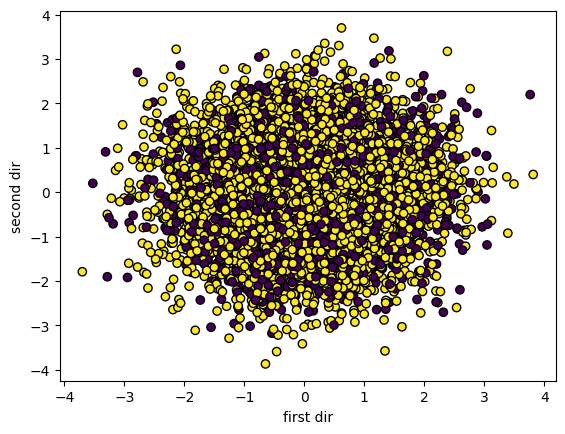

In [32]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Setting the probability for the true class
Prob_true = 0.7

# Generating the n_samples in 20 dimensions belonging to 2 categories
X, y = make_classification(n_features=20,
                           n_samples=10000,
                           n_classes=2,
                           # n_clusters_per_class=1,
                           # class_sep=1.5,
                           weights=[1 - Prob_true, Prob_true],
                           random_state=0
                           )

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Plotting the generated data
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolors='k')
plt.xlabel('first dir')
plt.ylabel('second dir')
plt.show()



###1.1. An analysis of the code above:
 1-our dataset can be seen as a matrix X with 10000 lines ie samples and 20 columns ie features
 2-the y is like a vector of n entries having the value 1 or 0 ie labels
 3-we have two classes: a false class with label 0 and a true class with label 1
 4-i also understood that the dataset is unbalanced because the weight ie the probability of having a point in the class one is 0.3 and the probability of having a point in the class two is 0.7
 5-for each class there are two clusters
 6-finally the seperation between the two calsses

 ***What is a class with two clusters?***

 When we say that a **class has two clusters**, it means that the data points within that class are grouped into two separate regions in the feature space. This arrangement can be visualized as follows:

1. **Single Cluster for Each Class (1 Cluster per Class)**:
   - If each class has only one cluster, then all points belonging to a given class (say class 0) will form a single, compact grouping in the feature space.
   - In this case, each class forms one continuous "blob" of data points.

2. **Multiple Clusters for Each Class (2 Clusters per Class)**:
   - When a class has two clusters, the points within that class are divided into two distinct groups, separated by some distance within the feature space.
   - For example, if class 0 has two clusters, there will be two distinct groupings of points with label 0, rather than one continuous group.
   - This can happen naturally in real-world data where the same label has subgroups with slightly different characteristics, causing the points to form multiple "islands" or clusters.

***Why Use Multiple Clusters per Class?***

Using multiple clusters per class can simulate more realistic data scenarios where classes are not uniformly distributed in a single, cohesive region. It adds complexity to the data, requiring models to handle more variation within a single class, which is often the case in real applications.


###1.2. An analysis of the plot:

In the plot, only the first two are being plotted:

  1. X[:, 0]: The first feature (or dimension) of each sample is plotted on the x-axis.
  2. X[:, 1]: The second feature of each sample is plotted on the y-axis.

As the dataset has 20 dimensions (20 features) in total, this 2D plot is just a partial view, **showing only the relationship between the first two features**.
We can't plot all the 20 features (high dimensional data) so for simplicity we do this approach.

We can check that there are two clases of data-points using dimensional reduction, for instance the PCA (we will study its meaning later on in the course)

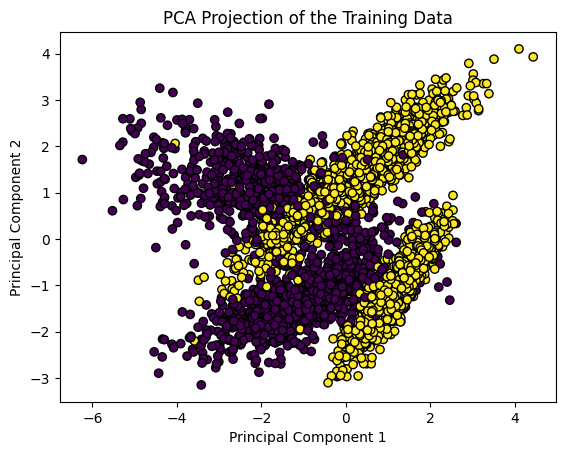

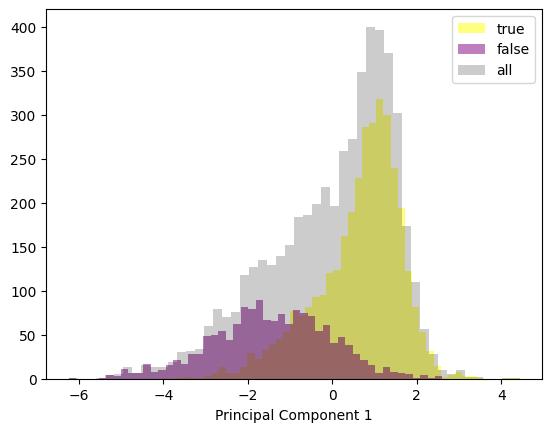

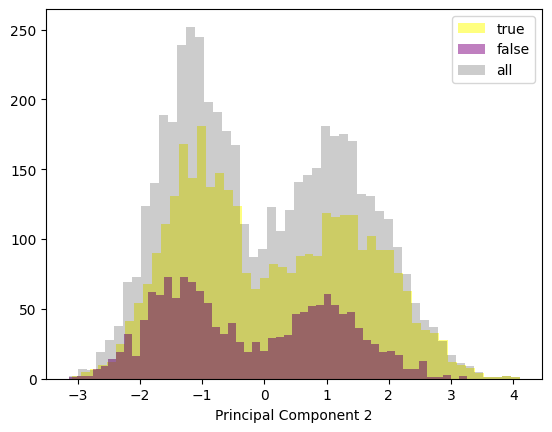

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plotting the training data in the new PCA space
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train, edgecolors='k')
plt.title('PCA Projection of the Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

index_1 = (y_train == 1)
index_0 = (y_train == 0)

plt.hist(X_train_pca[index_1, 0], bins=50, color='yellow', alpha=0.5, label='true')
plt.hist(X_train_pca[index_0, 0], bins=50, color='purple', alpha=0.5, label='false')
plt.hist(X_train_pca[:, 0], bins=50, color='black', alpha=0.2, label='all')
plt.legend()
plt.xlabel('Principal Component 1')
plt.show()

plt.hist(X_train_pca[index_1, 1], bins=50, color='yellow', alpha=0.5, label='true')
plt.hist(X_train_pca[index_0, 1], bins=50, color='purple', alpha=0.5, label='false')
plt.hist(X_train_pca[:, 1], bins=50, color='black', alpha=0.2, label='all')
plt.legend()
plt.xlabel('Principal Component 2')
plt.show()

## 2. Define different predictors

We need to define our 3 different predictors.

### No skills

The first predictor is a random guess. We will assign the label 1 to each entry with a probability \( p \).

In [34]:
def no_skills(X, p=0.5):
    return np.random.choice([0, 1], size=X.shape[0], p=[1 - p, p]) # return a random guess

### Naive: PCA based predictor

The second predictor is based on the first principal component. We will assign the label 1 to each entry with a value of the first principal component smaller than a given threshold.

> ***Why to choose the first component ?***
Choosing the **first principal component** (PC1) in PCA is common because:
By focusing on the first principal component, we give more importance to variance in the data for classification tasks. It's a practical approach that balances complexity and interpretability while aiming to achieve good predictive performance.

In [35]:
def PCA_based(X, threshold):
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X).reshape(len(X))
    return (X_pca < threshold).astype(int)

### Training: Logistic regression

We can learn to classify this data using logistic regression. I include a discussion about its training, but we do not need this for this lab.

Let us describe the data in terms of a probability function
$$p_{A,B}(\boldsymbol{x})=\frac{1}{1+e^{-(A+\boldsymbol{B}\cdot\boldsymbol{x})}},$$ using labeled data $(\boldsymbol{x}_k,y_k)$. We want to train the model such that the probability $p_k=p_{A,B}(\boldsymbol{x}_k)=1$ for $y_k=1$ and 0 for $y_k=0$. For this purpose, we can define a log loss
$$L=-\sum_{k} y_k\log p_k -(1-y_k)\log p_k $$
(it is clear that $L$ is minimized $p_k=1$ when $y_k=1$ and $p_k=0$ when $y_k=0$).
One can then minimize it by calculating the gradient
$$\frac{\partial L}{\partial A}=\sum_k (p_k-y_k)=0$$
$$\frac{\partial L}{\partial \boldsymbol{B}}=\sum_k \boldsymbol{x}_k (p_k-y_k)=0$$
Which is solved numerically. As a result of this process, we obtain a way to assign to each data point a probability of being in the category $y=1$.

In [36]:
from sklearn.linear_model import LogisticRegression

def logistic(X_test, X_train, y_train):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return y_pred

## 3. Confusion matrix

Now we have a set of two pairs mutually incompatible events:

- **True cluster** being part of cluster $[0,1]$,
- **Predicted label**: getting $[-,+]$


### Confusion matrices

We need to compute the conditional probablities $P(0|+)$, $P(1|+)$, $P(0|-)$, $P(1|-)$, and the joint probabilities $P(0\cap +)$, $P(1\cap +)$, $P(0\cap -)$, $P(1\cap -)$.

The confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. The confusion matrix is a 2x2 table with counts of the following events:

- **True Negative (TN)**: The number of correct predictions that an entry is in the negative class.
- **False Positive (FP)**: The number of incorrect predictions that an entry is in the positive class.
- **False Negative (FN)**: The number of incorrect predictions that an entry is in the negative class.
- **True Positive (TP)**: The number of correct predictions that an entry is in the positive class.

We can visualize the confusion matrix as follows:

<table>
    <tr>
        <th></th>
        <th>Pred -</th>
        <th>Pred +</th>
    </tr>
    <tr>
        <th>Real 0</th>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <th>Real 1</th>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

**Exercise**: Write a function to compute the entries of the confusion matrix

In [37]:
def compute_confusion_matrix(y_test, y_pred):
  TN=0
  FP=0
  FN=0
  TP=0
  for i in range(len(y_pred)):
    if y_test[i]==0 and y_pred[i]==0:
      TN +=1
    elif y_test[i]==0 and y_pred[i]==1:
      FP +=1
    elif y_test[i]==1 and y_pred[i]==0:
      FN +=1
    else:
      TP +=1

  return TN, FP, FN, TP

It is more convenient to divide by the total number of entries to have an idea of the proportions of each case.

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>TNR </td>
    <td>FPR </td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>FNR </td>
    <td>TPR</td>
  </tr>
</table>

Such matrix represents the joint probabilities of the events. Here, the letter R stands for ratio, i.e. the proportion of each case. (It is different from the specificity and sensitivity, also called true negative rate and true positive rate, which are conditional probabilities).

**Exercise**:
1. Display the normalized confusion matrix for each of the predictors.
2. Based on the confusion matrices, which predictor is the best? Which predictor is the worst?
3. Considering the random classifier as a *Model baseline*, what can you say about the quality of the two other predictors?



---


 > **Important remark:**

 **Given that our dataset has an imbalance where about 70% of the cases are positive (i.e., P(1) ≈ 0.7), setting p = 0.7 for the no-skills predictor will provide a more relevant baseline that reflects our dataset's characteristics. This approach ensures that the no-skills predictor has the same proportion of positive and negative predictions as our actual data, making comparisons with other models more meaningful. This approach gives a realistic reference point that reflects the dataset's inherent imbalance and allows for fairer comparisons with other models, such as the PCA-based and logistic regression models.**


---




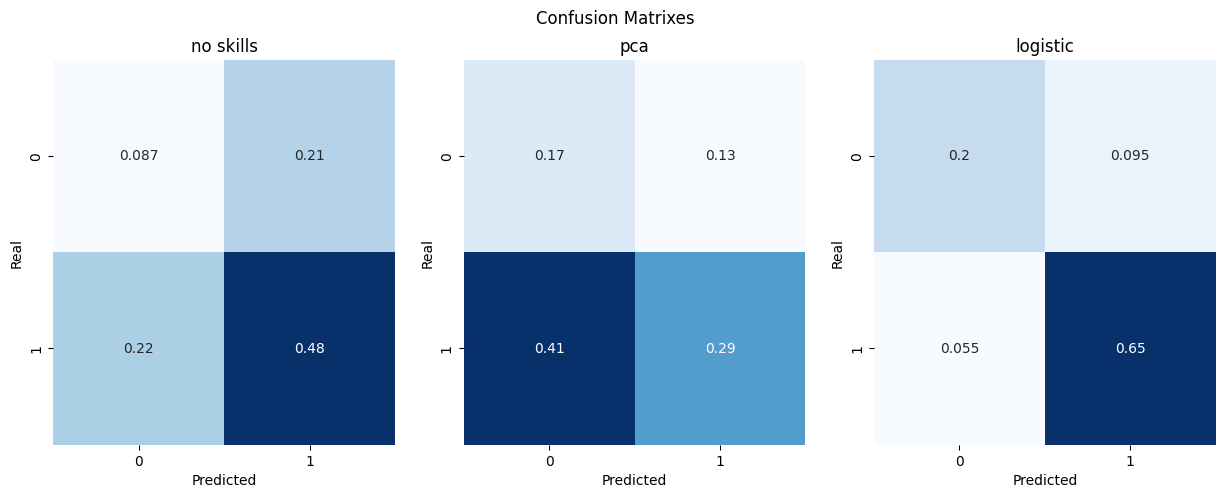

In [38]:
p=0.7 #default 0.5
y_pred_r = no_skills(X_train,p) # no skills
y_pred_pca = PCA_based(X_train,0) # pca prediction with threshold 0

y_pred_l = logistic(X_test, X_train, y_train) # logistic regression

titles = ['no skills', 'pca', 'logistic']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)

    cm = np.array([[TN, FP], [FN, TP]])
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(cm / np.sum(cm), annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()

***Answer to question 2:***

To say which is the best and the worst predictor we will make a comparison among the three predictors based on both the values of (TPR and TNP) which represent the ratio of correct predictions and the values of (FPR and FNR) which represent the ration the incorrect predictions.

Befor startinf this analysis there are some important definitions:
   * $TPR =P(+|1)=P(+\cap1)/P(1)$ and by Bayes' Theorem $TPR=P(+).P(1|+)/P(1)$

   * $TNR =P(-|0)=P(-\cap0)/P(0)$ and by Bayes' Theorem $TNR=P(-).P(0|-)/P(0)$

   * $FPR =P(+|0)=P(+\cap0)/P(0)$ and by Bayes' Theorem $FPR=P(+).P(0|+)/P(0)$

   * $FNR =P(-|1)=P(-\cap1)/P(1)$ and by Bayes' Theorem $FNR=P(-).P(1|-)/P(1)$

   * $P(1)=np.sum[y\_test==1]/len(y\_test)$
   * $P(0)=np.sum[y\_test==0]/len(y\_test)$
   * $P(+)=np.sum[y\_pred==1]/len(y\_pred)$
   * $P(-)=np.sum[y\_pred==0]/len(y\_pred)$

   * $C$ is the event "Have a correct prediction"
   * $I$ is the event "Have an incorrect prediction"
   * $P(C)=TPR+TNR$
   * $P(I)=FPR+FNR$

Here is a analysis of the results shown in the confusion matrix:
1. No skills predictor:
* 50% of TP and 9.3% of TN, this means 59,3% of the predictions are correct.
Which means:
    *   $P(C)=TPR+TNR=0.5+0.093=0.593$ ie the probability of classifying a point $x$ in the True class is $0.593$

* And we have 20% of FT and 20% of FN, this means 40% of the predictions are incorrect.
Then:
    *   $P(I)=FPR+FNR=0.2+0.2=0.4$ ie the probability of classifying a point $x$ in the False class is $0.4$
2. PCA based predictor:
* 29% of TP and 17% of TN, this means 46% of the results are correct.
Which means:
     *   $P(C)=TPR+TNR=0.29+0.17=0.46$ ie the probability of classifying a point $x$ in the True class is $0.46$

* And we have 41% of FT and 13% of FN, this means 54% of the predictions are incorrect.
Then:
    *   $P(I)=FPR+FNR=0.41+0.13=0.54$ ie the probability of classifying a point $x$ in the False class is $0.54$

3. Logistic regression predictor:

* 65% of TP and 20% of TN, this means 85% of the results are correct.
Which means:
     *   $P(C)=TPR+TNR=0.65+0.2=0.85$ ie the probability of classifying a point $x$ in the True class is $0.85$
* And we have 5.5% of FT and 9.5% of FN, this means 15% of the predictions are incorrect.
Then:
    *   $P(I)=FPR+FNR=0.055+0.095=0.15$ ie the probability of classifying a point $x$ in the False class is $0.15$

To summarize:
<table>
  <tr>
    <th></th>
    <th>% Correct </th>
    <th>% Incorrect </th>
  </tr>
  <tr>
    <th>No skills</th>
    <td>59.3 </td>
    <td>40 </td>
  </tr>
  <tr>
    <th>PCA based</th>
    <td>46 </td>
    <td>54</td>
  </tr>
    <tr>
    <th>Logistic regression</th>
    <td>85 </td>
    <td>15</td>
  </tr>
</table>

>Then we conclude that:
  * Based on the $P(C)$ the best predictor is the logistic regression predictor
  * Based on the $P(I)$ the worst predictor is the PCA based predictor

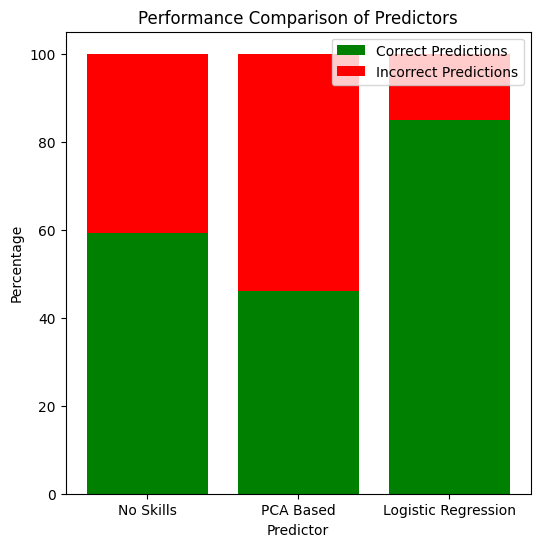

In [39]:
# Percentages of correct (P(C)) and incorrect (P(I)) predictions
predictors = ['No Skills', 'PCA Based', 'Logistic Regression']
P_C = [59.3, 46, 85]  # % Correct predictions
P_I = [40.7, 54, 15]    # % Incorrect predictions

fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(predictors, P_C, label='Correct Predictions', color='green')
ax.bar(predictors, P_I, bottom=P_C, label='Incorrect Predictions', color='red')

ax.set_xlabel('Predictor')
ax.set_ylabel('Percentage')
ax.set_title('Performance Comparison of Predictors')
ax.legend()
plt.show()

 Moreover, from the privious computations we can now compute the values of the conditional probablities $P(0|+)$, $P(1|+)$, $P(0|-)$, $P(1|-)$, and the joint probabilities $P(0\cap +)$, $P(1\cap +)$, $P(0\cap -)$, $P(1\cap -)$:
  

   * $P(1)=np.sum[y\_test==1]/len(y\_test)=0,7034 ≈ 0,7=p$
   * $P(0)=np.sum[y\_test==0]/len(y\_test)=0,2966 ≈ 0,3=1-p$

    * $P(1|+)=TPR.P(1)/P(+)$
    * $P(0|+)=FPR.P(0)/P(+) $
    * $P(0|-)=TNR.P(0)/P(-) $
    * $P(1|-)=FNR.P(1)/P(-) $
    * $P(1\cap+)=P(1)*TPR $
    * $P(0\cap+)=P(0)*FPR $
    * $P(0\cap-)=P(0)*TNR $
    * $P(1\cap-)=P(1)*FNR $  

In [40]:
pzero=np.sum(y_test==0)/len(y_test)
pzero

0.2966

In [41]:
pone=np.sum(y_test==1)/len(y_test)
pone

0.7034

1. For the no skills predictor we have:
   
  * $P(+)=np.sum[y\_pred\_r==1]/len(y\_pred\_r) = 0,698 ≈ 0,7=p$
  * $P(-)=np.sum[y\_pred\_r==0]/len(y\_pred\_r) = 0.302 ≈ 0.3=1-p$

    * $P(1|+)=TPR.P(1)/P(+) = 0.5*0.7034/0.698 = 0.5038$
    * $P(0|+)=FPR.P(0)/P(+) = 0.2*0.2966/0.698 = 0.084$
    * $P(0|-)=TNR.P(0)/P(-) = 0.093*0.2966/0.302 = 0.091$
    * $P(1|-)=FNR.P(1)/P(-) = 0.2*0.7034/0.302 =0.4658$
    * $P(1\cap+)=P(1)*TPR = 0.3517$
    * $P(0\cap+)=P(0)*FPR = 0.05932$
    * $P(0\cap-)=P(0)*TNR = 0.0275$
    * $P(1\cap-)=P(1)*FNR = 0.14$

  

In [42]:
print(np.sum(y_pred_r==1)/len(y_pred_r))
np.sum(y_pred_r==0)/len(y_pred_r)

0.693


0.307

2. For the PCA based predictor we have the following results:
   
  * $P(+)=np.sum[y\_pred\_pca==1]/len(y\_pred\_pca) = 0.42$
  * $P(-)=np.sum[y\_pred\_pca==0]/len(y\_pred\_pca) = 0.58$

    * $P(1|+)=TPR.P(1)/P(+) = 0.29*0.7034/0.42 = 0.4856$
    * $P(0|+)=FPR.P(0)/P(+) = 0.13*0.2966/0.42 = 0.0918$
    * $P(0|-)=TNR.P(0)/P(-) = 0.17*0.2966/0.58 = 0.0869$
    * $P(1|-)=FNR.P(1)/P(-) = 0.41*0.7034/0.58 =0.4972$
    * $P(1\cap+)=P(1)*TPR = 0.20$
    * $P(0\cap+)=P(0)*FPR = 0.038$
    * $P(0\cap-)=P(0)*TNR = 0.05$
    * $P(1\cap-)=P(1)*FNR = 0.28$

In [43]:
print(np.sum(y_pred_pca==1)/len(y_pred_pca))
np.sum(y_pred_pca==0)/len(y_pred_pca)

0.42


0.58

3. For the logistic regression predictor we have the following results:
   
  * $P(+)=np.sum[y\_pred\_l==1]/len(y\_pred\_l) = 0.7426$
  * $P(-)=np.sum[y\_pred\_l==0]/len(y\_pred\_l) = 0.2574$

    * $P(1|+)=TPR.P(1)/P(+) = 0.65*0.7034/0.7426 = 0.615$
    * $P(0|+)=FPR.P(0)/P(+) = 0.095*0.2966/0.7426 = 0.037$
    * $P(0|-)=TNR.P(0)/P(-) = 0.2*0.2966/0.2574 = 0.23$
    * $P(1|-)=FNR.P(1)/P(-) = 0.055*0.7034/0.2574 =0.15$
    * $P(1\cap+)=P(1)*TPR = 0.457$
    * $P(0\cap+)=P(0)*FPR = 0.0.28$
    * $P(0\cap-)=P(0)*TNR = 0.059$
    * $P(1\cap-)=P(1)*FNR = 0.038$

In [44]:
print(np.sum(y_pred_l==1)/len(y_pred_l))
np.sum(y_pred_l==0)/len(y_pred_l)

0.7426


0.2574

- Knowing that the **conditional probablities $P(0|+)$, $P(1|+)$, $P(0|-)$, $P(1|-)$**, show **the quality of the predictions** for each model by evaluating the likelihood that predictions match the true classes. They help us understand, in probabilistic terms, how well the model discriminates between classes in real situations. Higher values of $P(1|+)$ and $P(0|-)$ **indicate that the model effectively uses information from the data to predict accurately**, whereas higher values of $P(0|+)$ and $P(1|-)$  indicate issues like false positives and false negatives.

- And the joint probabilities $P(0\cap +)$, $P(1\cap +)$, $P(0\cap -)$, $P(1\cap -)$ show how well the model classifies each class and identifying where it makes the most mistakes.

 > **In conclusion:**
   * Logistic Regression has the highest rate of correct classifications both in terms of true positives $P(1|+)$ and true negatives $P(0|-)$, while also achieving the lowest rates of false positives and false negatives.
   * PCA-Based performs worst, with lower accuracy in identifying true positives and a higher rate of false negatives, showing it doesn't use the information effectively compared to Logistic Regression.
   * No Skills performs slightly better than PCA but worse than Logistic Regression, as expected for a baseline model.

    > *Which confirms the first conclusion made on the percentage of the correct and incorrect predictions, logistic regression is the best and PCA based is the worst.*

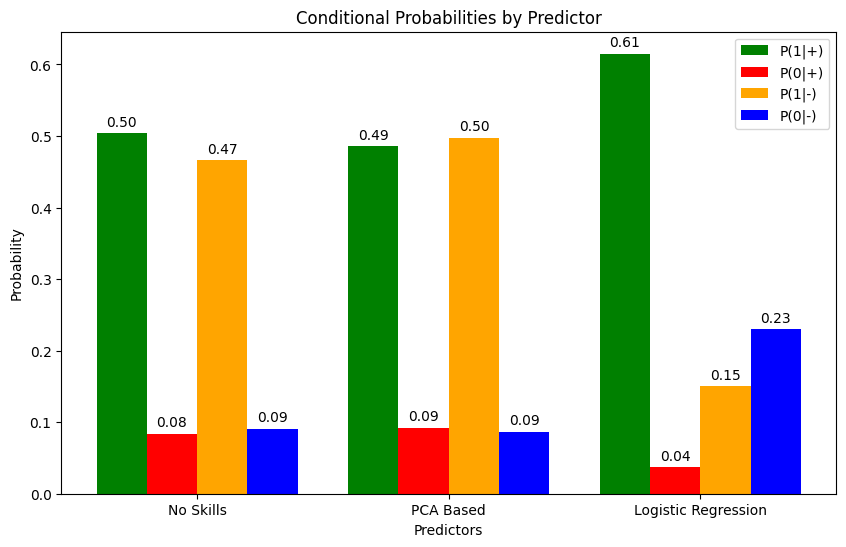

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the predictors: No Skills, PCA, Logistic
predictors = ['No Skills', 'PCA Based', 'Logistic Regression']
P_1_given_plus = [0.5038, 0.4856, 0.615]
P_0_given_plus = [0.084, 0.0918, 0.037]
P_1_given_minus = [0.4658, 0.4972, 0.15]
P_0_given_minus = [0.091, 0.0869, 0.23]

# Define the positions for each bar
x = np.arange(len(predictors))
width = 0.2  # Width of the bars

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - 1.5*width, P_1_given_plus, width, label='P(1|+)', color='green')
bar2 = ax.bar(x - 0.5*width, P_0_given_plus, width, label='P(0|+)', color='red')
bar3 = ax.bar(x + 0.5*width, P_1_given_minus, width, label='P(1|-)', color='orange')
bar4 = ax.bar(x + 1.5*width, P_0_given_minus, width, label='P(0|-)', color='blue')

# Labeling
ax.set_xlabel('Predictors')
ax.set_ylabel('Probability')
ax.set_title('Conditional Probabilities by Predictor')
ax.set_xticks(x)
ax.set_xticklabels(predictors)
ax.legend()

# Display the values on top of bars
for bar in [bar1, bar2, bar3, bar4]:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset for text
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


***Answer to question 3***:

Considering the no skills predictor is the baseline model, and by the conclusions and the analysis we made in the provious question:
  > * Logistic regression demonstrates **the highest quality** of prediction by effectively leveraging the information in the dataset.

  > * But the PCA-based predictor shows limitations and **performs below the baseline** set by the random classifier.




## Random confusion matrix

The random confusion matrix is a special case where **the events are assumed to be independent**. It is a baseline metric that can be used to evaluate the extent to which the predictors make use of the information in the dataset.

Remember that the independence of events implies the following equalities:

$P(0 \cap +) = P(0)P(+)$

$P(1 \cap +) = P(1)P(+)$

$P(0 \cap -) = P(0)P(-)$

$P(1 \cap -) = P(1)P(-)$

Therefore, the corresponding confusion matrix is:

<table>
  <tr>
    <th></th>
    <th>Pred -</th>
    <th>Pred +</th>
  </tr>
  <tr>
    <th>Real 0</th>
    <td>𝑃(0)𝑃(-)</td>
    <td>𝑃(0)𝑃(+)</td>
  </tr>
  <tr>
    <th>Real 1</th>
    <td>𝑃(1)𝑃(-)</td>
    <td>𝑃(1)𝑃(+)</td>
  </tr>
</table>

**Exercise**: Write a function to compute the random confusion matrix.

In [46]:
def compute_randomconfusion_matrix(y_test, y_pred):
    # Compute the random confusion matrix
    n=len(y_test) #nb of entries in both y_test and y_pred
    p0=np.sum(y_test==0)/n #P(0)
    p1=np.sum(y_test==1)/n #P(1)
    p0pred=np.sum(y_pred==0)/n #P(-)
    p1pred=np.sum(y_pred==1)/n #P(+)

    cm=[
        [p0*p0pred, p0*p1pred],
        [p1*p0pred, p1*p1pred]
    ]

    return cm

**Exercise**: Display the normalized confusion matrix for each of the predictors.

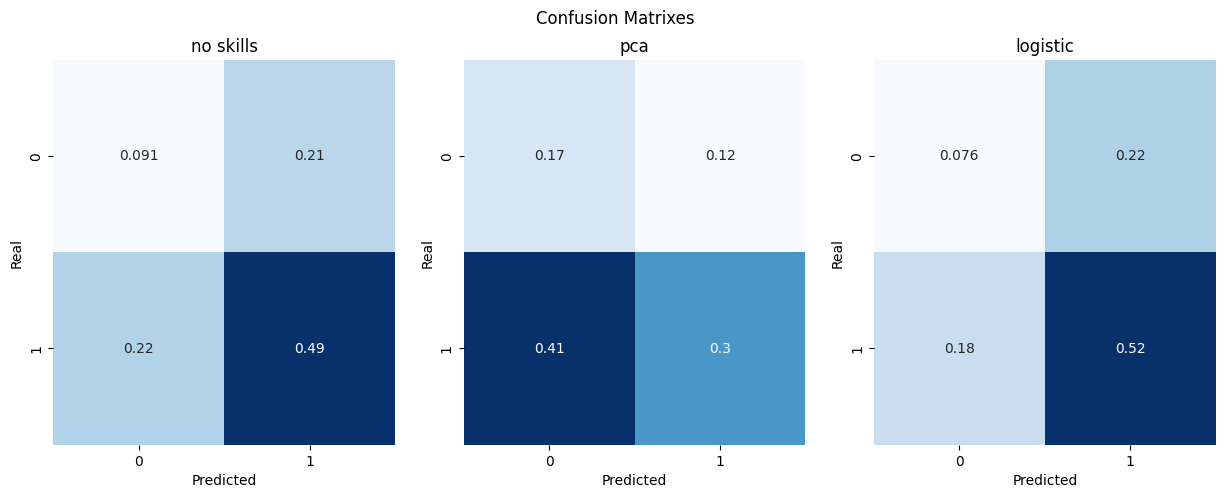

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    cm = compute_randomconfusion_matrix(y_test, y_pred)
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(normalized_cm, annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()

**Exercise**: Comparing the random confusion matrix with the confusion matrix of the predictors, what predictor makes best use of the information in the dataset? Which makes the worst use of the information?

***Answer***

The logistic regression makes the best use of the information in the dataset and the PCA based predictor makes the worst use.
>The reasons are:

  * The logistic regression uses both the relationship between the features $X_i$ and the outcome $y$ to make predictions where it maximizes the separation between classes by learning *(using X_train and y_test correspondance)* patterns that indicate if an observation is more likely to belong to one class or another.
  
  * The PCA based prediction is based on reducing the number of features by focusing on variance, not class separation. And in our case, we selected the first component with the highest variance (instead of using the maximum separation).




---


####Additional remarks:
let's take a look of the percentages of correct $P(C)$ and incorrect $P(I)$ predictions of each predictor where:
   * $P(1)=np.sum[y\_test==1]/len(y\_test)$
   * $P(0)=np.sum[y\_test==0]/len(y\_test)$
   * $P(+)=np.sum[y\_pred==1]/len(y\_pred)$
   * $P(-)=np.sum[y\_pred==0]/len(y\_pred)$
   * $FPR=P(0 \cap +) = P(0)P(+)$
   * $TPR=P(1 \cap +) = P(1)P(+)$
   * $TNR=P(0 \cap -) = P(0)P(-)$
   * $FNR=P(1 \cap -) = P(1)P(-)$
   * $C$ is the event "Have a correct prediction"
   * $I$ is the event "Have an incorrect prediction"
   * $P(C)=TPR+TNR$
   * $P(I)=FPR+FNR$

So from the Random Confusion matrix we have:

 <table>
  <tr>
    <th></th>
    <th>% Correct </th>
    <th>% Incorrect </th>
  </tr>
  <tr>
    <th>No skills</th>
    <td>57,8 </td>
    <td>42 </td>
  </tr>
  <tr>
    <th>PCA based</th>
    <td>47 </td>
    <td>53</td>
  </tr>
    <tr>
    <th>Logistic regression</th>
    <td>59,6 </td>
    <td>40</td>
  </tr>
</table>

We notice that:
 1. The logistic regression still the best predictor, based on the percentage of correct predictions, and the PCA is the worst
 2. The percentage of logistic regression with independent variables is less than the one computed in the privious evaluation. **Why?**
 3. The two probabilities (percentages $P(C)$ and $P(I)$) are now almost equal which means that the two predictions are almost equally probable.

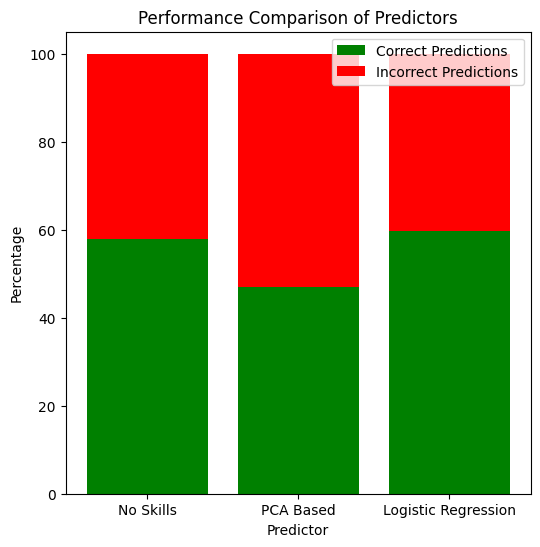

In [48]:
# Percentages of correct (P(C)) and incorrect (P(I)) predictions
predictors = ['No Skills', 'PCA Based', 'Logistic Regression']
P_C = [57.8, 47, 59.6]  # % Correct predictions
P_I = [42.2, 53, 40.4]    # % Incorrect predictions

fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(predictors, P_C, label='Correct Predictions', color='green')
ax.bar(predictors, P_I, bottom=P_C, label='Incorrect Predictions', color='red')

ax.set_xlabel('Predictor')
ax.set_ylabel('Percentage')
ax.set_title('Performance Comparison of Predictors')
ax.legend()
plt.show()



---



## 4. Quality estimators

We can define a set of quality metrics to evaluate the performance of the predictors. These metrics are:

- **Sensitivity (Recall)**: The proportion of actual positive cases that were correctly predicted.
- **Specificity**: The proportion of actual negative cases that were correctly predicted.
- **Precision**: The proportion of predicted positive cases that were correctly predicted.
- **Negative Predictive Value (NPV)**: The proportion of predicted negative cases that were correctly predicted.
- **Accuracy**: The proportion of correct predictions.
- **F1 Score**: The harmonic mean of precision and sensitivity.

   > NOTE:  The reason we use the harmonic mean as opposed to the regular mean, is that the harmonic mean punishes values that are further apart.
   

**Exercise**:
1. Give a closed-form expression for each of the quality metrics.
2. Define a function to compute each of the quality metrics.
3. Compute the quality metrics for each of the predictors.



**Answer to question 1:**

* $Sen= NbOfTruePositive / NbOfCases (1/.) = TP/(TP+FN)$
* $Spe= NbOfTrueNegative / NbOfCases(0/.) = TN/(TN+FP)$
* $Pre= NbOfTruePositive / NbOfCases(./+) =TP/(TP+FP)$
* $NPV= NbTrueNegative / NbOfCases(0/.) = TN/(TN+FP)$
* $Acc= (NbCases(0/-)+NbCases(1/+))/AllCases = (TN+TP)/(TN+TP+FN+FP)$
* $F1= 2*(Pre*Sen)/(Pre+Sen) = 2TP /(2TP+FN+FP)$

In [49]:
def metrics(y_test, y_pred):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)

    Sen = TP/(TP+FN)
    Spe = TN/(TN+FP)
    Pre = TP/(TP+FP)
    NPV = TN/(TN+FP)
    Acc = (TN+TP)/(TN+TP+FN+FP)
    F1 = 2*TP/(2*TP+FN+FP)

    return Sen, Spe, Pre, NPV, Acc, F1

In [50]:
def metrics_baseline(y_test, y_pred):
    cm = compute_randomconfusion_matrix(y_test, y_pred)
    cm = np.array(cm)
    TN, FP, FN, TP = cm.flatten()
    Sen_ran = TP/(TP+FN)
    Spe_ran = TN/(TN+FP)
    Pre_ran = TP/(TP+FP)
    NPV_ran = TN/(TN+FP)
    Acc_ran = (TN+TP)/(TN+TP+FN+FP)
    F1_ran = 2*TP/(2*TP+FN+FP)

    return Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran

In [51]:
def quality_estimators(y_test, y_pred):
    Sen, Spe, Pre, NPV, Acc, F1 = metrics(y_test, y_pred)
    Sen_ran, Spe_ran, Pre_ran, NPV_ran, Acc_ran, F1_ran = metrics_baseline(y_test, y_pred)

    print("**********************")

    print(f"{'Accuracy:':<25} {Acc * 100:.2f}% ({Acc_ran * 100:.2f}%)")
    print(f"{'F1 Score:':<25} {F1:.2f} ({F1_ran:.2f})")
    print(f"{'Sensitivity (Recall):':<25} {Sen * 100:.2f}% ({Sen_ran * 100:.2f}%)")
    print(f"{'Precision:':<25} {Pre * 100:.2f}% ({Pre_ran * 100:.2f}%)")
    print(f"{'Specificity:':<25} {Spe * 100:.2f}% ({Spe_ran * 100:.2f}%)")
    print(f"{'NPV:':<25} {NPV * 100:.2f}% ({NPV_ran * 100:.2f}%)")

    print("**********************")


In [52]:
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    print(titles[i])
    quality_estimators(y_test, y_pred)


no skills
**********************
Accuracy:                 57.08% (57.85%)
F1 Score:                 0.69 (0.70)
Sensitivity (Recall):     68.75% (69.30%)
Precision:                69.78% (70.34%)
Specificity:              29.40% (30.70%)
NPV:                      29.40% (30.70%)
**********************
pca
**********************
Accuracy:                 45.98% (46.75%)
F1 Score:                 0.52 (0.53)
Sensitivity (Recall):     41.46% (42.00%)
Precision:                69.43% (70.34%)
Specificity:              56.71% (58.00%)
NPV:                      56.71% (58.00%)
**********************
logistic
**********************
Accuracy:                 85.00% (59.87%)
F1 Score:                 0.90 (0.72)
Sensitivity (Recall):     92.12% (74.26%)
Precision:                87.26% (70.34%)
Specificity:              68.11% (25.74%)
NPV:                      68.11% (25.74%)
**********************




---


>Some ressources:

https://www.v7labs.com/blog/confusion-matrix-guide

https://towardsdatascience.com/guide-to-confusion-matrices-classification-performance-metrics-a0ebfc08408e

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


---



**Exercise**:
1. Based on the quality metrics, which predictor is the best? Which predictor is the worst?
2. Considering the random classifier as a *Model baseline*, what can you say about the quality of the two other predictors?
3. Based on the quality metrics and the random quality metrics, which predictor makes the best use of the information in the dataset? Which makes the worst use of the information?

**Answer**


---


  > Befor starting the comparision, we need to select the good metrics to use with our problem.
  Knowing that:
    
  - Recall is used to focus on limiting the FP (1/-)
  - Spec is used if the FP (0/+) are costly
  - Pre to focus on limiting FP (0/+)
  - NPV to be used if we want to focus on the accuracy of the negatives ie to ensure that the negatives are truly negatives
  - Accuracy good for balanced datasets
  - F1 score to focus on limiting both FN and FP and it's good for unbalanced datasets.

  > Imbalanced Datasets: Focus on F1 Score, Precision, Recall, Specificity, and NPV. AUC-ROC is also useful here as it shows how well the model differentiates between classes.

  >Balanced Datasets: Accuracy can be more reliable here, along with Precision, Recall, and F1 Score.

  > We will use as metrics:

  - F1 score
  - Spec
  - NPV
  

---

Question 1:
The best model is the logistic regression, the worst in the PCA based.



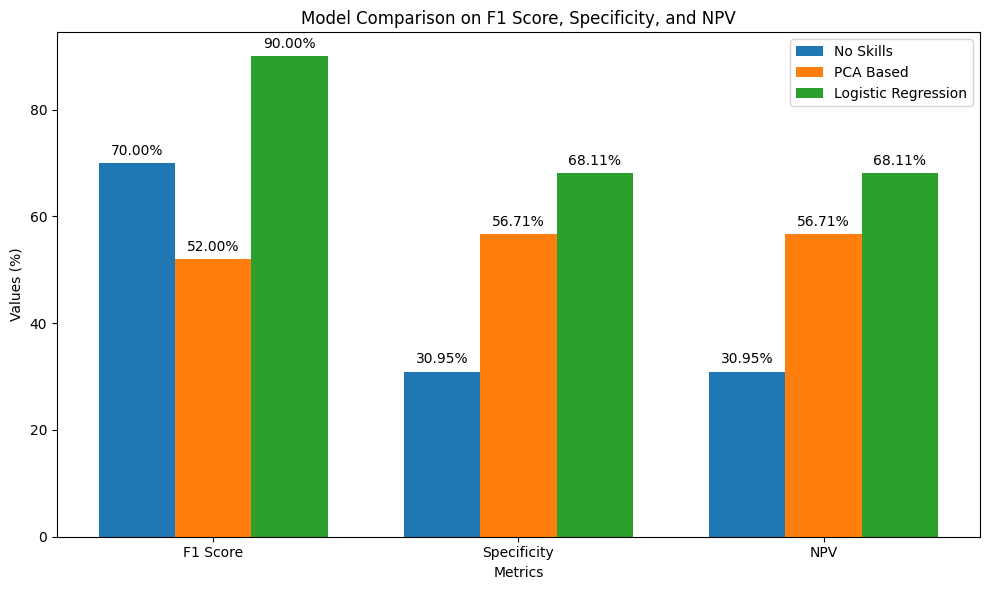

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Model results for each metric
metrics_list = ['F1 Score', 'Specificity', 'NPV']
no_skills_list = [70, 30.95, 30.95]
pca_list = [52, 56.71, 56.71]
logistic_list = [90, 68.11, 68.11]

# Bar width and positions
bar_width = 0.25
index = np.arange(len(metrics_list))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, no_skills_list, bar_width, label='No Skills')
bars2 = ax.bar(index + bar_width, pca_list, bar_width, label='PCA Based')
bars3 = ax.bar(index + 2 * bar_width, logistic_list, bar_width, label='Logistic Regression')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values (%)')
ax.set_title('Model Comparison on F1 Score, Specificity, and NPV')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics_list)
ax.legend()

# Adding data labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()




---
Question 2:
In order to chose the model how has the best quality and use the metrics above we will plot the AUC-ROC curve

 >**WHY THE AUC-ROC curve?**  **ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.**



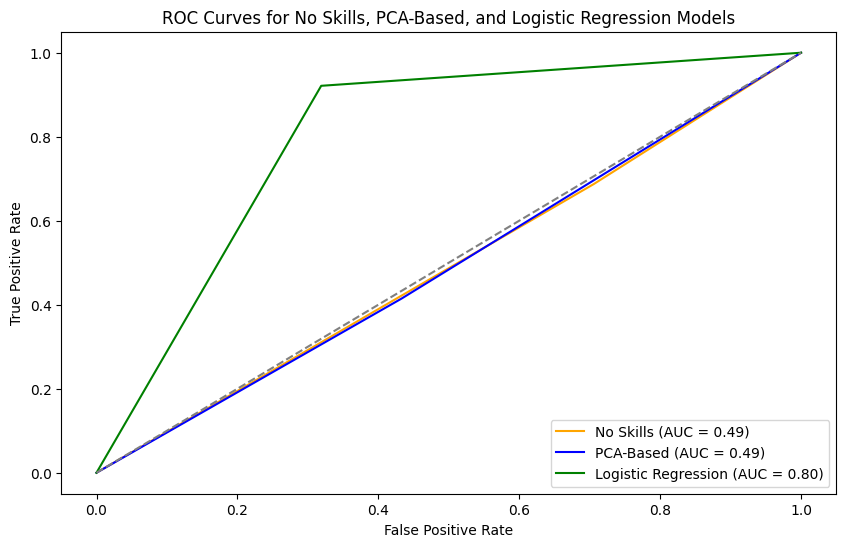

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generating the  ROC curves and computing AUC for each predictor
fpr_random, tpr_random, _ = roc_curve(y_test, y_pred_r)
auc_random = auc(fpr_random, tpr_random)

fpr_pca, tpr_pca, _ = roc_curve(y_test, y_pred_pca)
auc_pca = auc(fpr_pca, tpr_pca)

fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_l)
auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fpr_random, tpr_random, color='orange', label=f'No Skills (AUC = {auc_random:.2f})')
plt.plot(fpr_pca, tpr_pca, color='blue', label=f'PCA-Based (AUC = {auc_pca:.2f})')
plt.plot(fpr_logistic, tpr_logistic, color='green', label=f'Logistic Regression (AUC = {auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for No Skills, PCA-Based, and Logistic Regression Models')
plt.legend(loc="lower right")
plt.show()


From the plot, the quality of Logistic regression is better than the quality of the No skills predictor.
The PCA-based behaves almost like the No skills predictor but it's still wors than the no skills

**Answer 3:**
All the metrics of the logistic regression are higher than the metrics of the no skills predictor
All the metrics of the PCA based are lower than the metrics of the no skills predictor
So, the logistic regression makes the best use of the informations and the PCA-based makes the worst one.

## 5. Quality as a function of the parameters

Compute the accuracy of each method as function of the parameters of the predictor. What can you say about the quality of the predictors as a function of the parameters?

**Exercise**:
1. Compute the metrics of each method as a function of the parameters of the predictor.
2. Plot the metrics of each method as a function of the parameters of the predictor.
3. Based on the plot, which predictor is the best? Which predictor is the worst?
4. What can you say about the quality of the predictors as a function of the parameters?

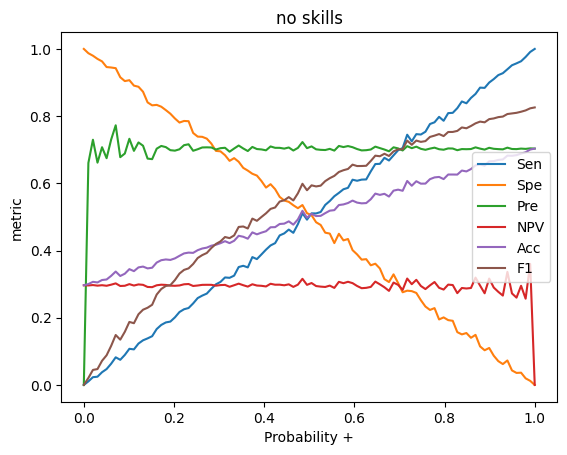

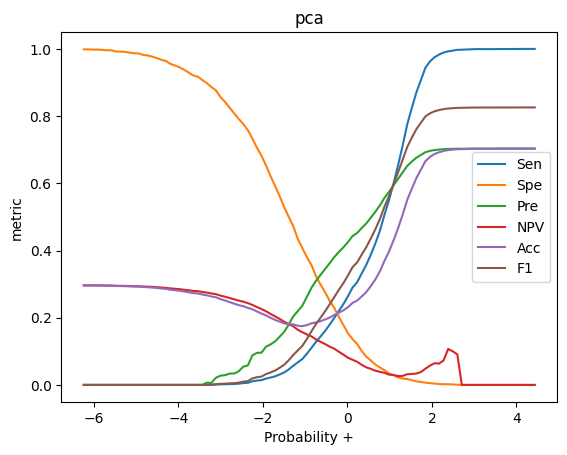

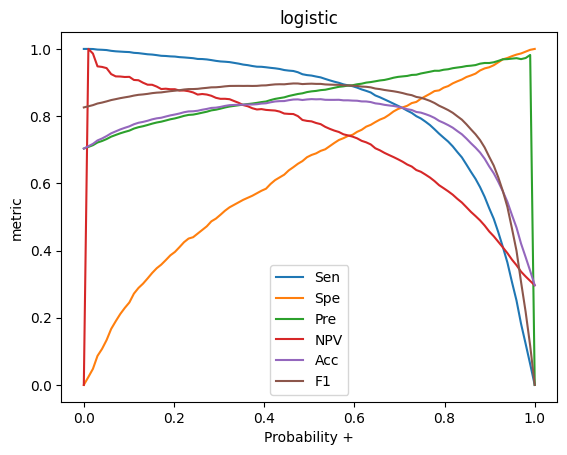

In [55]:
from typing_extensions import assert_type
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Compute metrics: Sensitivity, Specificity, Precision, NPV, Accuracy, F1 Score
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    pre = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * pre * sen / (pre + sen) if (pre + sen) > 0 else 0
    return [sen, spe, pre, npv, acc, f1]

N = 100  # number of parameters

## random

range_noskill = np.linspace(0, 1, N)
Metrics_noskill = np.zeros((N, 6))
for ith, p in enumerate(range_noskill):
    y_pred_th = np.random.choice([0, 1], size=X_test.shape[0], p=[1 - p, p]) # no skills
    Metrics_noskill[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[0])
plt.plot(range_noskill, Metrics_noskill[:, 0], label='Sen')
plt.plot(range_noskill, Metrics_noskill[:, 1], label='Spe')
plt.plot(range_noskill, Metrics_noskill[:, 2], label='Pre')
plt.plot(range_noskill, Metrics_noskill[:, 3], label='NPV')
plt.plot(range_noskill, Metrics_noskill[:, 4], label='Acc')
plt.plot(range_noskill, Metrics_noskill[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## pca


range_pca = np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), N)
Metrics_pca = np.zeros((N, 6))
for ith, p in enumerate(range_pca):
    y_pred_th = PCA_based(X_test,p) # pca prediction with threshold p
    Metrics_pca[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[1])
plt.plot(range_pca, Metrics_pca[:, 0], label='Sen')
plt.plot(range_pca, Metrics_pca[:, 1], label='Spe')
plt.plot(range_pca, Metrics_pca[:, 2], label='Pre')
plt.plot(range_pca, Metrics_pca[:, 3], label='NPV')
plt.plot(range_pca, Metrics_pca[:, 4], label='Acc')
plt.plot(range_pca, Metrics_pca[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

## logistic

range_log = np.linspace(0, 1, N)
Metrics_log = np.zeros((N, 6))

#training the model
clf_log = LogisticRegression(solver='lbfgs', max_iter=1000)
clf_log.fit(X_train, y_train)

for ith, p in enumerate(range_log):
    y_pred_th = (clf_log.predict_proba(X_test)[:, 1] >= p).astype(int) # logistic regression
    Metrics_log[ith] = np.nan_to_num(metrics(y_test, y_pred_th))

plt.title(titles[2])
plt.plot(range_log, Metrics_log[:, 0], label='Sen')
plt.plot(range_log, Metrics_log[:, 1], label='Spe')
plt.plot(range_log, Metrics_log[:, 2], label='Pre')
plt.plot(range_log, Metrics_log[:, 3], label='NPV')
plt.plot(range_log, Metrics_log[:, 4], label='Acc')
plt.plot(range_log, Metrics_log[:, 5], label='F1')
plt.xlabel('Probability +')
plt.ylabel('metric')
plt.legend()
plt.show()

range_pca = np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), N)


**Answer 1:**
Based on the plots, the best predictor is LOGISTIC REGRESSION , the worst is the no skills predictor.

**Answer 2:**
The quality of the predictors depends on the value of the its parameter, indeed:
 * **No skill predictor:**
 The more the value of p increases and gets closer to 1, the more Acc and F1 increases towards 0.7 (logically since the dataset is balanced with 0.7 of "1") and 0.8 respectively. As well as the Sen increases to reach a maximum value of 1 which is logical because with high probability p the no skills predictor generates more 1 than 0, on the other hand Spe and NPV reach their maximum value because the predictor generates more 1 than 0.
So, increasing the value of p towards 1.0 improves the predictor metrics but this does not reflect the quality of the predictor in terms of separability of the two classes because it does not take into account in any way the data of the dataset it is purely random that it predicts 1 with a probability of p and 0 with a probability 1-p.

* **PCA-based predictor:**
The higher the threshold value, the better the metrics and therefore the quality of the predictor. Indeed, with a theshold value of 2, sen, Pre, F1, Acc reach their maximum values: 1, 0.7, 0.8, 0.7 respectively. On the other hand, the values ​​of SPE and NPV decrease to almost zero values. This reflects the fact that the predictor limits the number of FN and FP to the maximum and predicts TN and TP at best. However the prediction still the worst.

* **Logistic regression:**
achieves better performance for a probability value p=0.5 because the predictor will have better separability at this probability value.


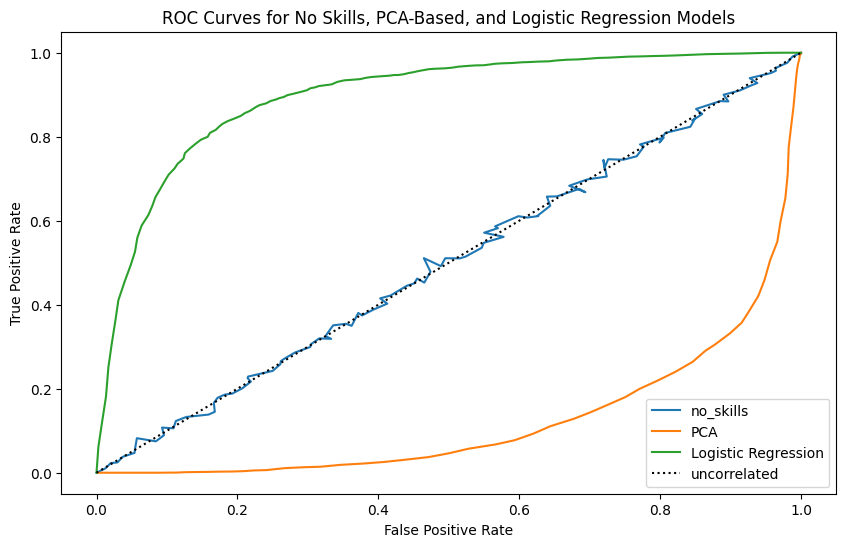

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(1 - Metrics_noskill[:,1], Metrics_noskill[:,0],label="no_skills")
plt.plot(1 - Metrics_pca[:,1], Metrics_pca[:,0],label=f"PCA")
plt.plot(1 - Metrics_log[:,1], Metrics_log[:,0],label=f"Logistic Regression")
plt.plot([0,1],[0,1],':',color='black', label='uncorrelated')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for No Skills, PCA-Based, and Logistic Regression Models')
plt.legend()
plt.show()

## 6. Further optimization

Here we will try to optimize the parameters of no_skills and pca based on the above graphs, in order to maximise F1_Score

In order to do so, we will use p = 1 for the no_skills predictor and a threshold of 2 for the PCA

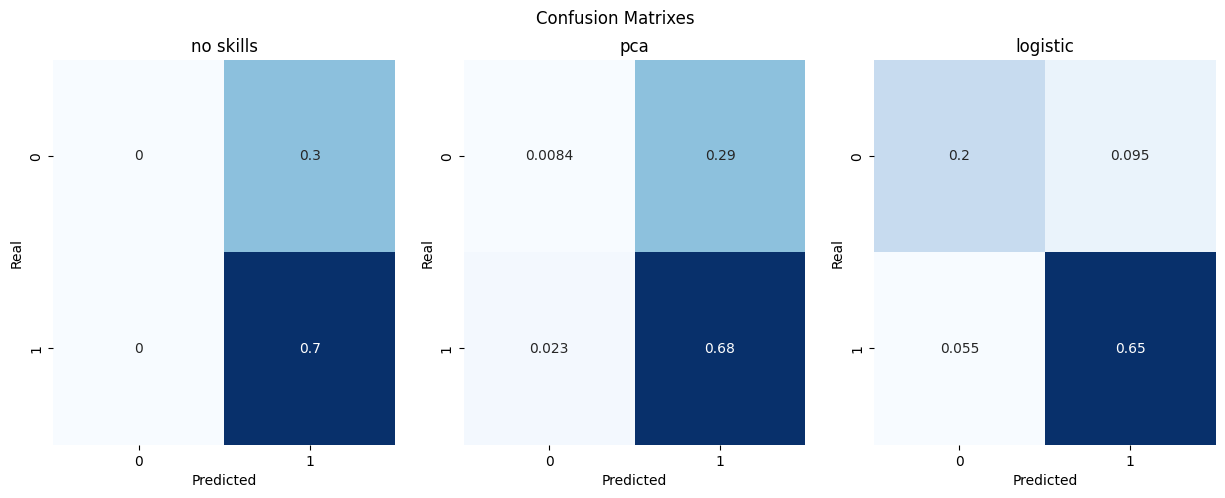

In [57]:
y_pred_r = no_skills(X_train, p = 1) # no skills
y_pred_pca = PCA_based(X_train,2) # pca prediction with threshold 2

y_pred_l = logistic(X_test, X_train, y_train) # logistic regression

titles = ['no skills', 'pca', 'logistic']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    TN, FP, FN, TP = compute_confusion_matrix(y_test, y_pred)

    cm = np.array([[TN, FP], [FN, TP]])
    normalized_cm = cm / np.sum(cm)

    ax[i].set_title(titles[i])
    sns.heatmap(cm / np.sum(cm), annot=True, cmap="Blues", cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Real')
plt.suptitle('Confusion Matrixes')
plt.show()

In [58]:
for i, y_pred in enumerate([y_pred_r, y_pred_pca, y_pred_l]):
    print(titles[i])
    quality_estimators(y_test, y_pred)

no skills
**********************
Accuracy:                 70.34% (70.34%)
F1 Score:                 0.83 (0.83)
Sensitivity (Recall):     100.00% (100.00%)
Precision:                70.34% (70.34%)
Specificity:              0.00% (0.00%)
NPV:                      0.00% (0.00%)
**********************
pca
**********************
Accuracy:                 68.88% (69.06%)
F1 Score:                 0.81 (0.81)
Sensitivity (Recall):     96.73% (96.86%)
Precision:                70.25% (70.34%)
Specificity:              2.83% (3.14%)
NPV:                      26.75% (3.14%)
**********************
logistic
**********************
Accuracy:                 85.00% (59.87%)
F1 Score:                 0.90 (0.72)
Sensitivity (Recall):     92.12% (74.26%)
Precision:                87.26% (70.34%)
Specificity:              68.11% (25.74%)
NPV:                      78.48% (25.74%)
**********************


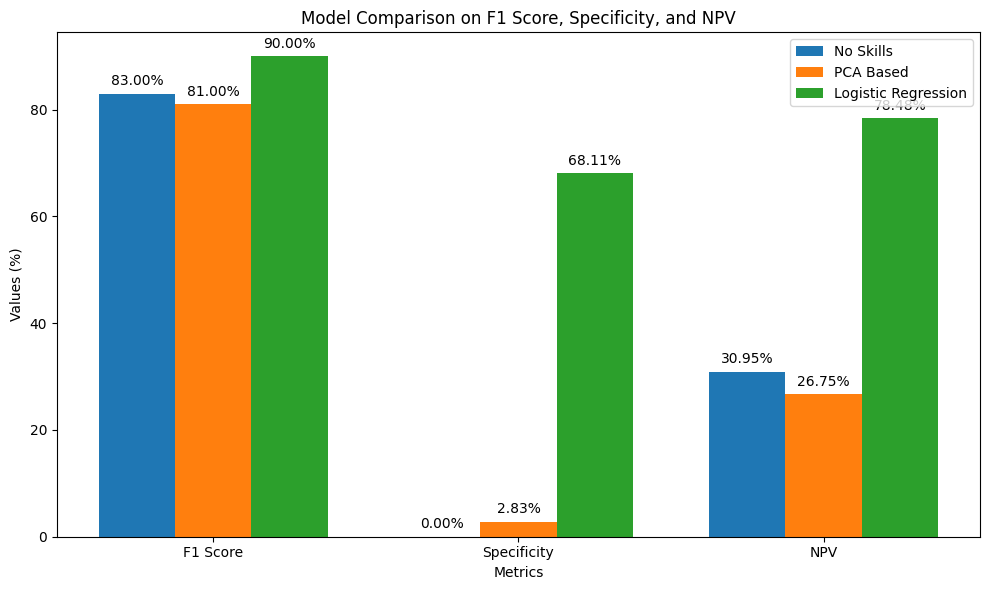

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Model results for each metric
metrics_list = ['F1 Score', 'Specificity', 'NPV']
no_skills_list = [0.83*100, 0, 30.95]
pca_list = [0.81*100, 2.83, 26.75]
logistic_list = [0.90*100, 68.11, 78.48]

# Bar width and positions
bar_width = 0.25
index = np.arange(len(metrics_list))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, no_skills_list, bar_width, label='No Skills')
bars2 = ax.bar(index + bar_width, pca_list, bar_width, label='PCA Based')
bars3 = ax.bar(index + 2 * bar_width, logistic_list, bar_width, label='Logistic Regression')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values (%)')
ax.set_title('Model Comparison on F1 Score, Specificity, and NPV')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics_list)
ax.legend()

# Adding data labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


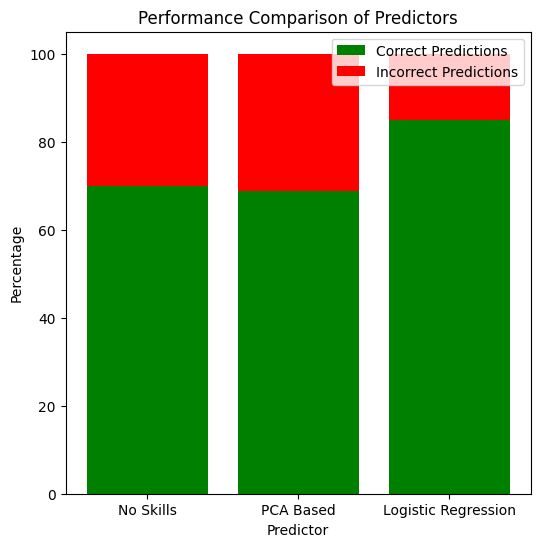

In [60]:
# Percentages of correct (P(C)) and incorrect (P(I)) predictions
predictors = ['No Skills', 'PCA Based', 'Logistic Regression']
P_C = [70, 68.84, 85]  # % Correct predictions
P_I = [30, 31.16, 15]    # % Incorrect predictions

fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(predictors, P_C, label='Correct Predictions', color='green')
ax.bar(predictors, P_I, bottom=P_C, label='Incorrect Predictions', color='red')

ax.set_xlabel('Predictor')
ax.set_ylabel('Percentage')
ax.set_title('Performance Comparison of Predictors')
ax.legend()
plt.show()

This results indicate that the PCA is at best comparable to the no_skills, and overall not efficient for our use-case, while the Logistic Regression still proves to be the best model by a good margin.